In [2]:
%pip install --upgrade keras keras_preprocessing

Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np
import os
import re


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



# SVM
from sklearn.svm import LinearSVC  # for text, linear SVM usually works best
from sklearn.svm import SVC

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# LSTM (use "Base" conda env)
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
# from keras._tf_keras.keras.models import Sequential
# from keras._tf_keras.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



nltk.download('punkt_tab')
#nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification




#os.chdir(r"C:\Users\raned\Documents\GitHub\PostModeration")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


This notebook will start off with preprocessing the two csv files to train different supervised learning models. 
- Removal of usernames, URLs, and special characters
- Lowercasing text
- Tokenization (nltk or spaCy): breaking text into smaller units 
- Stopword removal: remove common words that become index terms ("and", "or", "the", "in")
- Lemmatization: reduces words to their base or dictionary form
- TF-IDF vectorization for feature extraction: a technique that converts text data into numerical vectors, representing the importance of words in a document relative to a collection of documents, by combining term frequency with inverse document frequency

**count**: number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were

**hate_speech**: number of CF users who judged the tweet to be hate speech

**offensive_language**: number of CF users who judged the tweet to be offensive

**neither**: number of CF users who judged the tweet to be neither offensive nor non-offensive

**class**: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither


---
---
---


## Start Here
The code below combines the two datasets into one dataframe before any thing gets preprocessed. Since SVMs and LSTMs require different formats for their text input data, I created new columns 'tokenized_clean_text' and 'cleaned_text' that contain different formats of text so that training_data_df['Content'] doesn't have to be re-preprocessed all over again wheneveer we switch between models. 

In [4]:
# function to create a word cloud
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

def create_wordcloud(df):
    # first check if df has both labels. if only one label, then create a word cloud for that label
    if df['Label'].nunique() != 2:
        # create a word cloud for the only label present
        text = " ".join(df['Content'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        image = wordcloud.to_array()
        plt.figure(figsize=(10, 5))
        plt.imshow(image, interpolation='bilinear')
        plt.title('Word Cloud for Label {}'.format(df['Label'].unique()[0]))
        plt.axis('off')
        plt.show()
        return
        
    non_malicious_text = " ".join(df[df['Label'] == 0]['Content'])
    malicious_text = " ".join(df[df['Label'] == 1]['Content'])
    non_malicious_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="Blues").generate(non_malicious_text)
    malicious_wordcloud = WordCloud(width=800, height=400, background_color='white',colormap="Reds").generate(malicious_text)
    non_malicious_image = non_malicious_wordcloud.to_array()
    malicious_image = malicious_wordcloud.to_array()
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(non_malicious_image, interpolation='bilinear')
    plt.title('Non Malicious Tweets')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(malicious_image, interpolation='bilinear')
    plt.title('Malicious Tweets')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


#visualize word count
def visualize_word_count(df):
    # Create a new column for word count
    temp_df = df.copy()
    temp_df['Word Count'] = temp_df['Content'].apply(lambda x: len(str(x).split()))
    
    # Plot the distribution of word counts
    plt.figure(figsize=(10, 5))
    sns.histplot(temp_df['Word Count'], bins=30, kde=True)
    plt.title('Distribution of Word Counts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()







In [5]:

# these two variables should must always add up to 14,500 to ensure balance between hate speech vs. non hate speech 

emotion_data_size = 4500          #dictates how much of the training data comes from text.csv (emotion data)
hateSpeechBalanced_size = 3500     #dictates how much of the training data comes from HateSpeechDatasetBalanced.csv 

# ====== RESULTS ===========
#HateSpeechBalanced_size = 3000: SVM 90%, LSTM 89%
#HateSpeechBalanced_size = 4300: SVM 88%, LSTM 87%
#HateSpeechBalanced_size = 6300: SVM 87%, LSTM 84%
#HateSpeechBalanced_size = 8300: SVM 85%, LSTM 82%


Since all this data is to train the model on what "clean" tweets should look like, we should be careful with the model possibly learning that clean tweets tend to start with "I" or must include the word "feel/feeling"

no_feeling_size:  3825
feeling_size:  101
feeling_df shape:  (405133, 2)
no_feeling_df shape:  (3825, 2)
(4330, 3)
Label
0    4330
Name: count, dtype: int64


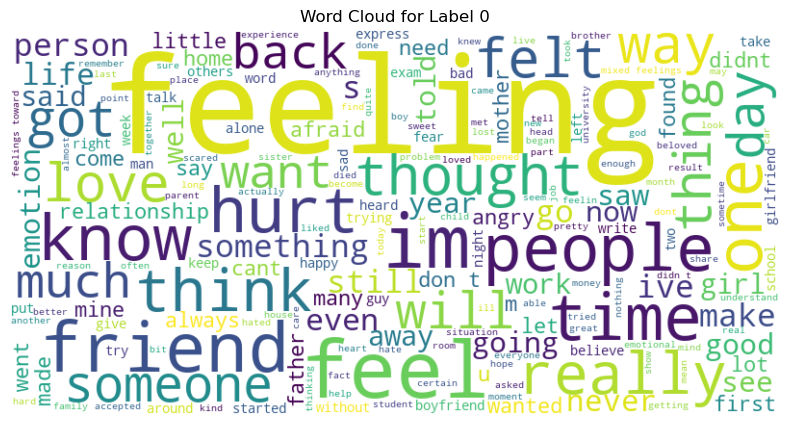

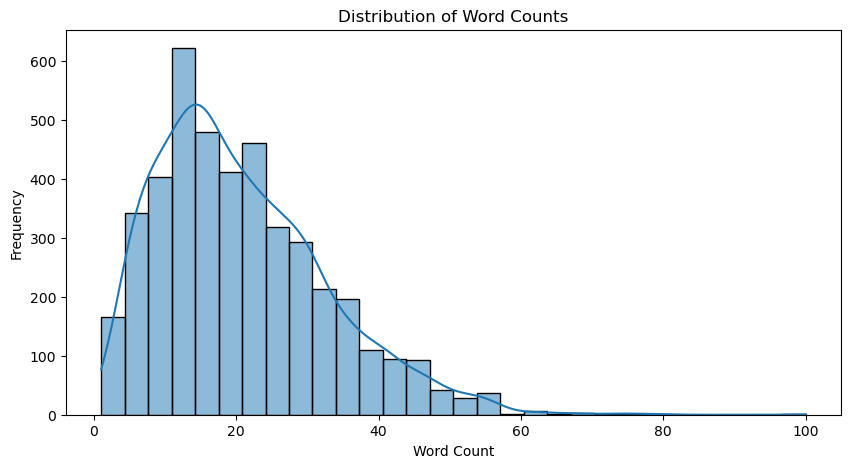

In [6]:

# ================== Additional Dataset: text.csv =======================
emotions_df = pd.read_csv("TrainingData/text.csv")
emotions_df.drop(columns=['Unnamed: 0'],inplace=True)

# most of the rows contain the word "feeling/feels/feel" which might skew the data, the code below will ensure the data is balanced in that respect
no_feeling_size = int(emotion_data_size*0.85)
feeling_size = int((emotion_data_size-no_feeling_size)*0.15)

feeling_df = emotions_df[emotions_df['text'].str.contains(r'\bfeel(?:s|ing)?\b', case=False, regex=True)]
no_feeling_df= emotions_df[~emotions_df['text'].str.contains(r'\bfeel(?:s|ing)?\b', case=False, regex=True)].sample(n=no_feeling_size, random_state=42).copy()

print("no_feeling_size: ",no_feeling_size)
print("feeling_size: ",feeling_size)
print("feeling_df shape: ",feeling_df.shape)
print("no_feeling_df shape: ",no_feeling_df.shape)

emotions = pd.DataFrame()
for i in range(0,5):
    temp = feeling_df[feeling_df['label']==i].sample(n=feeling_size, random_state=42).copy()
    emotions = pd.concat([emotions,temp],ignore_index=True)


emotions = pd.concat([emotions,no_feeling_df],ignore_index=True)

emotions['Content'] = emotions['text']
emotions['Label'] = emotions['label']
emotions.drop(columns=['text','label'],inplace=True)
emotions['Label']= emotions['Label'].replace(to_replace=[0,1,2,3,4,5], value = [0,0,0,0,0,0])
emotions['Source'] = 'text.csv (emotion data)'
print(emotions.shape)
print(emotions['Label'].value_counts())

create_wordcloud(emotions)
visualize_word_count(emotions)



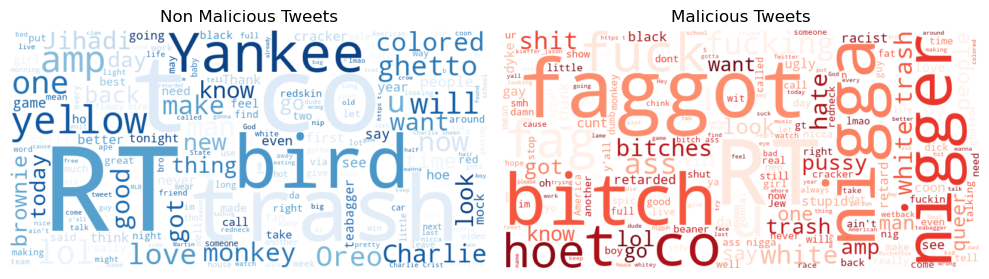

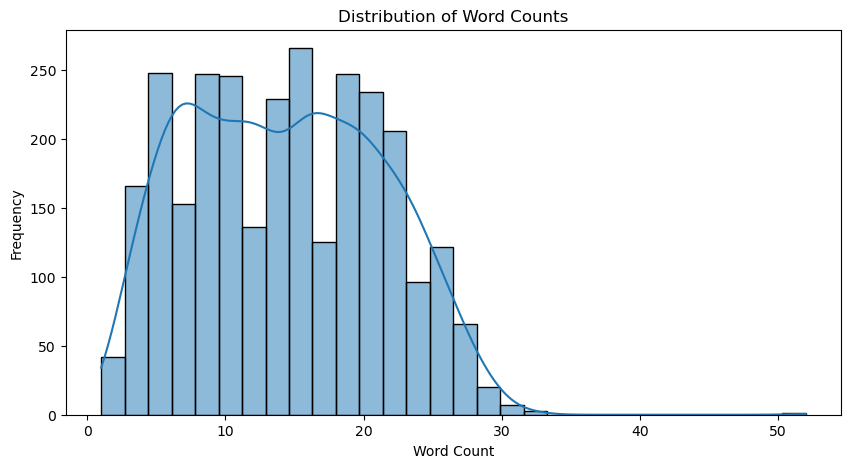

In [7]:

# since both datasets have "Content/Tweet" and "Label/class" columns, the following code will merge the two datasets into one dataframe while maintaining balance

# #============================================ labeled_data.csv ============================================
df1 = pd.read_csv("TrainingData/labeled_data.csv")
#reduced_df1['class'].value_counts()    #1430 tweets marked at hate-speech, so we will extract 1430 marked for hate speech and 1430 that aren't

# get rid of all the extra columns that aren't relevant
reduced_df1 = df1[['tweet','class']]

# extracts 1430 marked for hate speech and 1430 that aren't and combine into one df
hatespeech = reduced_df1[reduced_df1['class']==0].sample(n=1430, random_state=42).copy() # hate speech
nonHateful = reduced_df1[reduced_df1['class']==2].sample(n=1430, random_state=42).copy() # not hate speech
sampled_hatespeech_df = pd.concat([hatespeech,nonHateful])


# edit the values in 'Class' so that they match the values for HateSpeechDatasetBalanced.csv 
# Clean: 0, Hate speech: 1
sampled_hatespeech_df['Content'] = sampled_hatespeech_df['tweet']
sampled_hatespeech_df['Label'] = sampled_hatespeech_df['class'].replace(to_replace=[0,2], value = [1,0])
sampled_hatespeech_df['Source'] = 'labeled_data.csv'
sampled_hatespeech_df = sampled_hatespeech_df.drop(columns=['tweet','class'])



create_wordcloud(sampled_hatespeech_df)
visualize_word_count(sampled_hatespeech_df)





(27000, 5)
(27000, 3)


/var/folders/nh/b84nc6pd1353r3vmzmt9rxw80000gn/T/ipykernel_42507/2084606180.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Source'] = 'HateSpeechDatasetBalanced.csv'


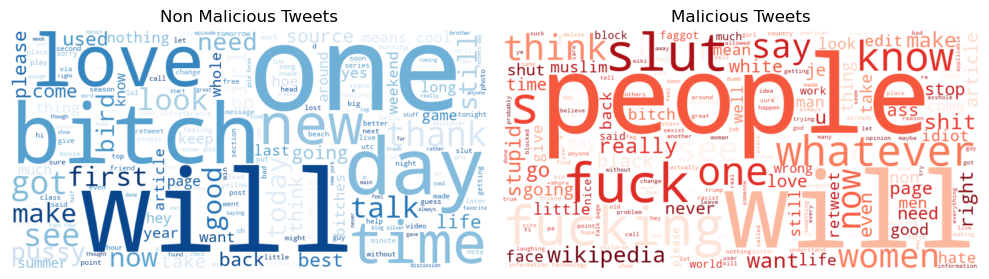

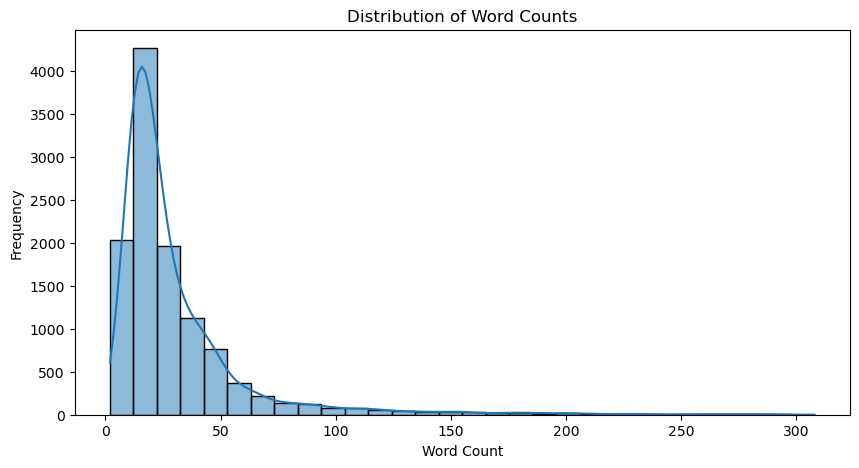

In [8]:

#============================================ HateSpeechDatasetBalanced.csv ============================================
# df = pd.read_csv("TrainingData/HateSpeechDatasetBalanced.csv")
df = pd.read_csv("TrainingData/combined_df.csv")

df_subset = df.sample(n=27000, random_state=42).copy()
print(df_subset.shape)

temp_df = df_subset[['Content','Label']]
temp_df['Source'] = 'HateSpeechDatasetBalanced.csv'
print(temp_df.shape)

hatespeech = temp_df[temp_df['Label']==1].sample(n=8000, random_state=42).copy() # hate speech
nonHateful = temp_df[temp_df['Label']==0].sample(n=hateSpeechBalanced_size, random_state=42).copy() # nonhate speech


# combine both datasets into one:
training_data_df = pd.concat([hatespeech,nonHateful],ignore_index=True)
training_data_df['Source'] = 'HateSpeechDatasetBalanced.csv'

create_wordcloud(training_data_df)
visualize_word_count(training_data_df)


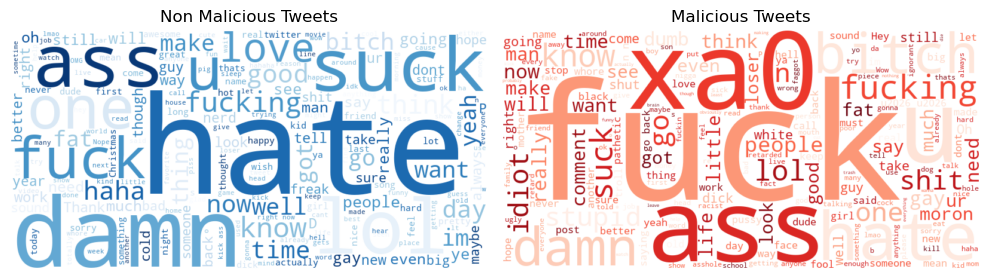

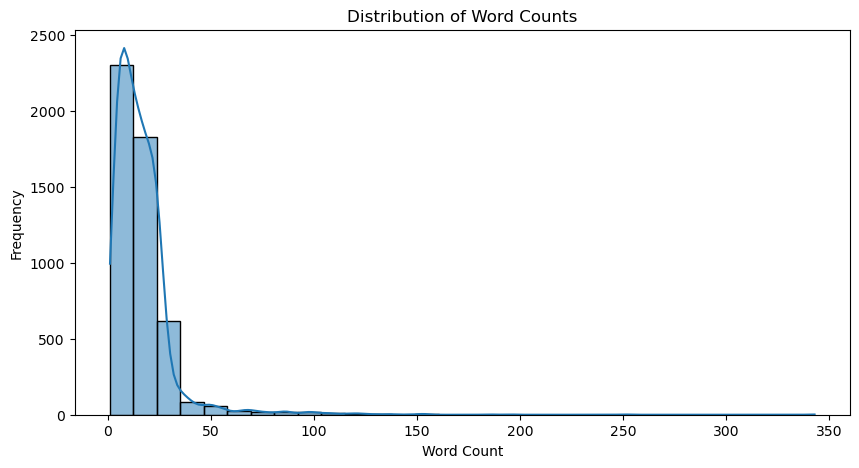

Label
0    2541
1    2459
Name: count, dtype: int64


In [9]:
# cyberbullying data
df_cyberbullying = pd.read_csv("TrainingData/CyberBullyingCommentsDataset2.csv").sample(n=5000, random_state=42).copy()
df_cyberbullying['Content'] = df_cyberbullying['Text']
df_cyberbullying['Label'] = df_cyberbullying['CB_Label']

# drop the extra columns
df_cyberbullying = df_cyberbullying[['Content','Label']]
df_cyberbullying['Source'] = 'CyberBullyingCommentsDataset2.csv'

create_wordcloud(df_cyberbullying)
visualize_word_count(df_cyberbullying)

print(df_cyberbullying['Label'].value_counts())

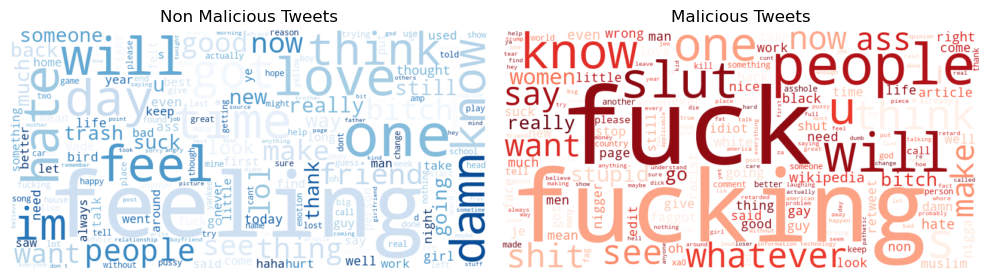

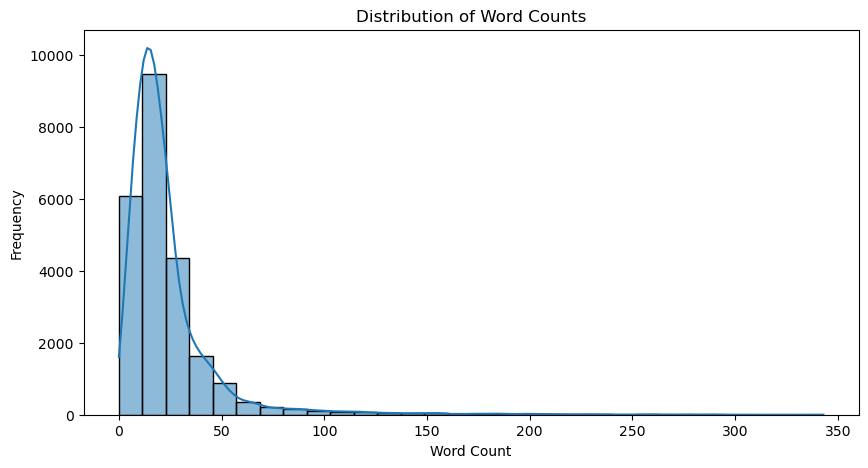

Label
1    11889
0    11801
Name: count, dtype: int64
                                             Content  Label  \
0  retweet it all really great website use it rig...      1   
1  utc boy am i getting tired of this look if i a...      1   
2  i dare you to report me bitch you failed again...      1   
3  is anyone else ever really bored with arguing ...      1   
4  orange river succus for press secretary orange...      1   

                          Source  
0  HateSpeechDatasetBalanced.csv  
1  HateSpeechDatasetBalanced.csv  
2  HateSpeechDatasetBalanced.csv  
3  HateSpeechDatasetBalanced.csv  
4  HateSpeechDatasetBalanced.csv  


In [10]:
# combine all datasets into one
sampled_hatespeech_df = pd.concat([sampled_hatespeech_df,emotions])
training_data_df = pd.concat([training_data_df,sampled_hatespeech_df],ignore_index=True)
training_data_df = pd.concat([training_data_df,df_cyberbullying],ignore_index=True)

# clean training data
training_data_df['Content']= training_data_df['Content'].astype(str).str.casefold()
clean_content = training_data_df['Content'].str.replace(r'(rt)?\s?@\w+:?', ' ', regex=True).str.replace(r'http.+', ' ', regex=True)
training_data_df['Content'] = clean_content

create_wordcloud(training_data_df)
visualize_word_count(training_data_df)

# check if the data is balanced 
print(training_data_df['Label'].value_counts())

print(training_data_df.head())

### SVM

In [11]:
# Cleaning for models that require sparse vectors as text  (SVMs,Logistic Regression, etc)
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
#tokenization, stop words, and lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) #stopwords

def clean_tokenize(text):
    tokens = word_tokenize(text)  # splits into words and keeps contractions
    tokens = [t for t in tokens if t.isalpha()]  # keep only alphabetic tokens
    tokens = [t for t in tokens if t != "rt" and t not in stop_words]  # remove 'rt' and stopwords
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return lemmatized


training_data_df['cleaned_tokens'] = training_data_df['Content'].apply(clean_tokenize)
training_data_df['tokenized_cleaned_text'] = training_data_df['cleaned_tokens'].apply(lambda x: ' '.join(x))
training_data_df['tokenized_cleaned_text'] = training_data_df['tokenized_cleaned_text'].fillna('')

print(training_data_df.head())

tfidf = TfidfVectorizer(ngram_range=(1,3))      # playing around with ngram_range, might go up to 3

X = tfidf.fit_transform(training_data_df['tokenized_cleaned_text'])  # Features
y = training_data_df['Label']  # Target labels

print("TF-IDF shape:", X.shape)
print(tfidf.get_feature_names_out()[:100])

                                             Content  Label  \
0  retweet it all really great website use it rig...      1   
1  utc boy am i getting tired of this look if i a...      1   
2  i dare you to report me bitch you failed again...      1   
3  is anyone else ever really bored with arguing ...      1   
4  orange river succus for press secretary orange...      1   

                          Source  \
0  HateSpeechDatasetBalanced.csv   
1  HateSpeechDatasetBalanced.csv   
2  HateSpeechDatasetBalanced.csv   
3  HateSpeechDatasetBalanced.csv   
4  HateSpeechDatasetBalanced.csv   

                                      cleaned_tokens  \
0  [retweet, really, great, website, use, right, ...   
1  [utc, boy, getting, tired, look, attacking, on...   
2  [dare, report, bitch, failed, put, block, wiki...   
3  [anyone, else, ever, really, bored, arguing, r...   
4  [orange, river, succus, press, secretary, oran...   

                              tokenized_cleaned_text  
0  retweet r

In [12]:
# SVM training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearSVC(C=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

legend = {0: "' is permitted", 1: "' has been flagged for hate speech."}


def moderate(tweet):
    tweet_clean = " ".join(clean_tokenize(tweet))
    tweet_vec = tfidf.transform([tweet_clean])
    pred = model.predict(tweet_vec)[0]
    print("The tweet: '",tweet,legend[pred],". Value: ",pred)
    
    
moderate("stfu you piece of trash")  # 1
moderate("Hope you're having a good day you cute piece of shit")  # 0
moderate("hello there")
moderate("today was fine")



[[2196  182]
 [ 297 2063]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2378
           1       0.92      0.87      0.90      2360

    accuracy                           0.90      4738
   macro avg       0.90      0.90      0.90      4738
weighted avg       0.90      0.90      0.90      4738

The tweet: ' stfu you piece of trash ' has been flagged for hate speech. . Value:  1
The tweet: ' Hope you're having a good day you cute piece of shit ' is permitted . Value:  0
The tweet: ' hello there ' is permitted . Value:  0
The tweet: ' today was fine ' is permitted . Value:  0


In [173]:
# hyperparamter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [ 0.1, 1, 10],  # Regularization strength
    'class_weight': [None, 'balanced']
}
grid = GridSearchCV(
    estimator=LinearSVC(max_iter=5000),
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='f1',  # You can also use 'accuracy', 'precision', etc.
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

grid.fit(X, y)
# grid = GridSearchCV(SVC(), param_grid, cv=3)
#grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...........................C=0.1, class_weight=None; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.5s
[CV] END .............................C=1, class_weight=None; total time=   0.6s
[CV] END .........................C=1, class_weight=balanced; total time=   0.5s
[CV] END .............................C=1, class_weight=None; total time=   0.6s
[CV] END .........................C=1, class_weight=balanced; total time=   0.5s
[CV] END .........................C=1, class_weig

### LSTM

In [13]:
# Cleaning data for models that require sequences of integers as text input  (LSTM/Deep Nets)


def clean_for_lstm(text):
    text = re.sub(r'(rt)?\s?@\w+:?', '', text)
    text = re.sub(r'(RT)?\s?@\w+:?', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\'\s]', '', text)
    return text.lower().strip()

# clean_tweet = tweet_column.str.replace(r'(rt)?\s?@\w+:?', ' ', regex=True).str.replace(r'http.+', ' ', regex=True).str.replace(r'\W+', ' ', regex=True)
training_data_df['cleaned_text'] = training_data_df['Content'].apply(clean_for_lstm)
training_data_df.head()


,Content,Label,Source,cleaned_tokens,tokenized_cleaned_text,cleaned_text
0,retweet it all really great website use it rig...,1,HateSpeechDatasetBalanced.csv,"[retweet, really, great, website, use, right, ...",retweet really great website use right god smi...,retweet it all really great website use it rig...
1,utc boy am i getting tired of this look if i a...,1,HateSpeechDatasetBalanced.csv,"[utc, boy, getting, tired, look, attacking, on...",utc boy getting tired look attacking one hell ...,utc boy am i getting tired of this look if i a...
2,i dare you to report me bitch you failed again...,1,HateSpeechDatasetBalanced.csv,"[dare, report, bitch, failed, put, block, wiki...",dare report bitch failed put block wikipedia h...,i dare you to report me bitch you failed again...
3,is anyone else ever really bored with arguing ...,1,HateSpeechDatasetBalanced.csv,"[anyone, else, ever, really, bored, arguing, r...",anyone else ever really bored arguing random p...,is anyone else ever really bored with arguing ...
4,orange river succus for press secretary orange...,1,HateSpeechDatasetBalanced.csv,"[orange, river, succus, press, secretary, oran...",orange river succus press secretary orange jui...,orange river succus for press secretary orange...


In [14]:

# LSTM requires sequences of integers, NOT vectors
texts = training_data_df['cleaned_text'].values
labels = training_data_df['Label'].values

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=50)  # 50 = max length

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=50),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    #Dense(16, activation='softmax'),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax'),

   

    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train,
                    epochs=5, # 7 epochs: 77% , 5 epochs had 77% accuracy, 3 epochs has 79%
                    batch_size=64,
                    validation_split=0.1)

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


legend = {0: "' is permitted", 1: "' has been flagged for hate speech."}

def moderate_lstm(tweet):
    cleaned = clean_for_lstm(tweet)
    print(cleaned)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, padding='post', maxlen=50)
    pred = model.predict(padded)[0][0]
    xx = lambda x : 1 if x > 0.7 else 0
    print('The tweet: "',tweet,legend[xx(pred)], ". Value: ",pred )
    return 1 if pred > 0.7 else 0



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6445 - loss: 0.6439 - val_accuracy: 0.8803 - val_loss: 0.4756
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9059 - loss: 0.4457 - val_accuracy: 0.8887 - val_loss: 0.4167
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9279 - loss: 0.3695 - val_accuracy: 0.8982 - val_loss: 0.3755
Epoch 4/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9404 - loss: 0.3133 - val_accuracy: 0.8977 - val_loss: 0.3473
Epoch 5/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9497 - loss: 0.2705 - val_accuracy: 0.9030 - val_loss: 0.3236
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2360
           1       0.91      0.89      0.90      2378

    accuracy                           0.90      4738
   macro avg       0.90      0.90      0.90      4738
weighted avg       0.90      0.90      0.9

In [15]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2360
           1       0.91      0.89      0.90      2378

    accuracy                           0.90      4738
   macro avg       0.90      0.90      0.90      4738
weighted avg       0.90      0.90      0.90      4738

[[2142  218]
 [ 263 2115]]


In [189]:
moderate_lstm("hello there")
moderate_lstm("today was fine")
moderate_lstm("twirl")
moderate_lstm("stfu you piece of trash")  # 1
moderate_lstm("Hope you're having a good day you cute piece of shity")
moderate_lstm("I love you")
moderate_lstm("I hate you")
moderate_lstm("women shouldnt vote")
moderate_lstm("you yellow people are useless")
              

hello there
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The tweet: " hello there ' is permitted . Value:  0.14220078
today was fine
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The tweet: " today was fine ' is permitted . Value:  0.15220354
twirl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " twirl ' is permitted . Value:  0.15345635
stfu you piece of trash
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " stfu you piece of trash ' has been flagged for hate speech. . Value:  0.8741209
hope you're having a good day you cute piece of shity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " Hope you're having a good day you cute piece of shity ' is permitted . Value:  0.2565988
i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The tweet: " I love you ' is permitted . Value:  0.14752626
i hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " I hate you ' is permitted . Value:  0.36191374
women shouldnt vote
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " women shouldnt vote ' has been flag

1

In [16]:
# evaluate model 
moderate_lstm("hello there")
moderate_lstm("today was fine")
moderate_lstm("twirl")
moderate_lstm("stfu you piece of trash")  # 1
moderate_lstm("Hope you're having a good day you cute piece of shity")
moderate_lstm("I love you")
moderate_lstm("I hate you")
moderate_lstm("women shouldnt vote")
moderate_lstm("you yellow people are useless")
moderate_lstm("I love my black jackets")
              




              


hello there
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The tweet: " hello there ' is permitted . Value:  0.17215393
today was fine
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The tweet: " today was fine ' is permitted . Value:  0.1902056
twirl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The tweet: " twirl ' is permitted . Value:  0.18176538
stfu you piece of trash
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " stfu you piece of trash ' has been flagged for hate speech. . Value:  0.8464033
hope you're having a good day you cute piece of shity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " Hope you're having a good day you cute piece of shity ' is permitted . Value:  0.21400946
i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " I love you ' is permitted . Value:  0.17378005
i hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " I hate you ' has been flagged for hate speech. . Value:  0.78905684
women shouldnt vote
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " women shouldnt

0

In [17]:
# save the model
model.save('lstm_model.h5')
# save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
